In [12]:
import numpy as np
from partition_decode.dataset import generate_gaussian_parity, load_mnist
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from partition_decode.df_utils import (
    get_tree_evals,
    get_forest_evals,
    get_forest_irm,
    get_tree_irm,
)
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, zero_one_loss
from scipy.linalg import block_diag

In [3]:
X_train, y_train = generate_gaussian_parity(
    n_samples=100, angle_params=0, random_state=1, cov_scale=1.0
)
X_test, y_test = generate_gaussian_parity(
    n_samples=1024, angle_params=0, random_state=1234, cov_scale=1.0
)

X_train, y_train = load_mnist(
    random_state = 1,
    train=True,
    n_samples=1000,
    save_path="/mnt/ssd3/ronan/pytorch",
    onehot=True
)

X_test, y_test = load_mnist(
    random_state = 1234,
    train=False,
    n_samples=10000,
    save_path="/mnt/ssd3/ronan/pytorch",
    onehot=True
)

In [70]:
def get_tree_weights(tree, X):
    """Regression tree"""
    n = X.shape[0]
    leaves = tree.apply(X).reshape(n, -1) # n, 1 w/ L unique
    y_hat = tree.predict(X) # n, k
    _, indices = np.unique(leaves, axis=0, return_index=True)
    weights = np.asarray([
        y_hat[indices, i]
        for i in range(y_hat.shape[1])
    ])
    return weights
    
def get_forest_weights(model, X):
    tree_weights = [
        get_tree_weights(tree, X)
        for tree in model.estimators_
    ]
    
    shapes = [i.shape for i in tree_weights]
    out = np.zeros([shapes[0][0], sum(s[1] for s in shapes), len(shapes)])
    
    r = 0
    for i, (_, rr) in enumerate(shapes):
        out[:, r:r + rr, i] = tree_weights[i]
        r += rr
    
    return out / len(tree_weights)

def df(irm, p=2):
    evals = np.linalg.svd(irm, compute_uv=False)**p
    H_trace = evals.sum()
    return H_trace

def get_forest_hat_irm(irm):
    H = irm @ irm.T
    H /= np.sum(H, axis=1)
    return H

In [75]:
n_estimators = [1, 1, 1, 1, 1, 1, 5, 10, 20]
max_depths = [2, 4, 8, 16, 32, None, None, None, None, None]
gen_errors = []
irms = []
weights = []
train_errors = []
test_errors = []
for n_trees, max_depth in zip(n_estimators, max_depths):
    model = RandomForestRegressor(bootstrap=True, n_estimators=n_trees, max_depth=max_depth, n_jobs=-2, max_features=2)
    model = model.fit(X_train, y_train)
    y_train_hat = model.predict(X_train)
    y_test_hat = model.predict(X_test)
    train_errors.append(mean_squared_error(y_train, y_train_hat))
    test_errors.append(mean_squared_error(y_test, y_test_hat))
    gen_errors.append(test_errors[-1] - train_errors[-1])
    irms.append(get_forest_irm(model, X_train, scale=True))
    weights.append(get_forest_weights(model, X_train))

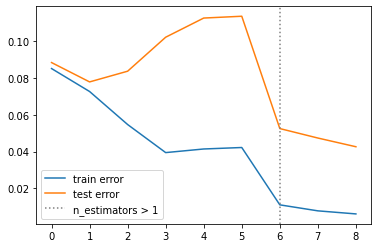

In [76]:
plt.plot(np.arange(len(train_errors)), train_errors, label='train error')
plt.plot(np.arange(len(test_errors)), test_errors, label='test error')
plt.axvline(np.argmax(np.asarray(n_estimators) > 1), ls=':', c='grey', label='n_estimators > 1')
plt.legend()
plt.show()

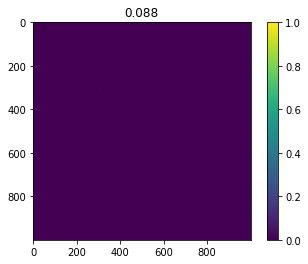

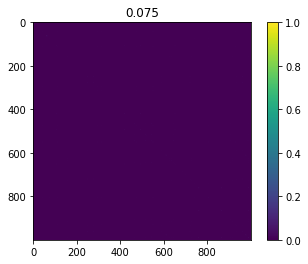

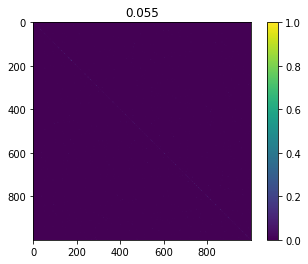

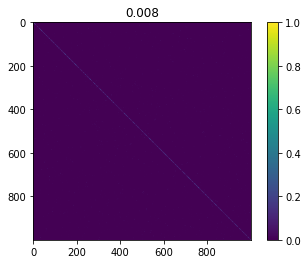

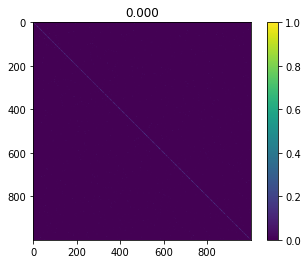

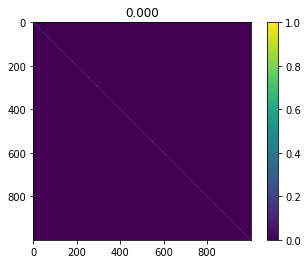

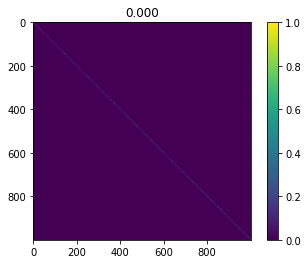

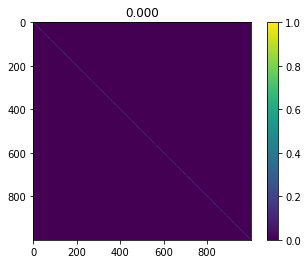

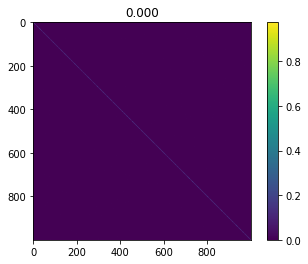

In [50]:
for irm in irms:
    H = irm @ irm.T
    err = mean_squared_error(y_train, H @ y_train)
    plt.imshow(H)
    plt.title(f'{err:.3f}')
    plt.colorbar()
    plt.show()
    break

In [63]:
H_dfs = np.asarray([
    [
        df(irm @ irm.T @ np.sum([np.diag(y_train[:, i])
        for i in range(len(np.unique(y_train, axis=0)))], axis=0))
    ] for irm in irms
])

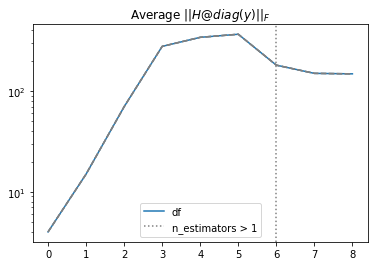

In [64]:
# H diag(y) norm
plt.plot(np.arange(len(H_dfs)), np.mean(H_dfs, axis=1), label='df')
plt.plot(np.arange(len(H_dfs)), np.mean(H_dfs, axis=1) + 2*np.sqrt(np.var(H_dfs, axis=1)), ls='--', c='grey')
plt.plot(np.arange(len(H_dfs)), np.mean(H_dfs, axis=1) - 2*np.sqrt(np.var(H_dfs, axis=1)), ls='--', c='grey')
plt.axvline(6, ls=':', c='grey', label='n_estimators > 1')
plt.yscale('log')
plt.legend()
plt.title(r'Average $||H @ diag(y)||_F$')
plt.show()

In [85]:
MW_norms = np.asarray([
    [
        (np.linalg.norm(np.ceil(M) @ W.T, ord=2) / np.sqrt(M.shape[0]))
        for W in Ws
    ] for M, Ws in zip(irms, weights)
])

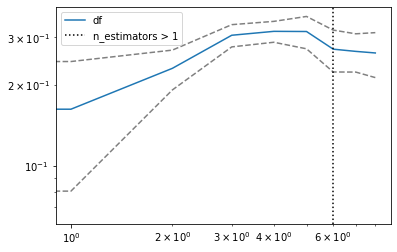

In [86]:
# X = 1 representation
mat = MW_norms
plt.plot(np.arange(len(mat)), np.mean(mat, axis=1), label='df')
plt.plot(np.arange(len(mat)), np.mean(mat, axis=1) + 2*np.sqrt(np.var(mat, axis=1)), ls='--', c='grey')
plt.plot(np.arange(len(mat)), np.mean(mat, axis=1) - 2*np.sqrt(np.var(mat, axis=1)), ls='--', c='grey')
plt.axvline(6, ls=':', c='black', label='n_estimators > 1')
plt.yscale('log')
plt.xscale('log')
plt.legend()
# plt.title(r'Average $||MW^T||_F$')
plt.show()

In [88]:
MW_norms = np.asarray([
    [
        (np.linalg.norm(np.ceil(M) @ W, ord=2) / np.sqrt(M.shape[0]))
        for W in Ws
    ] for M, Ws in zip(irms, weights)
])

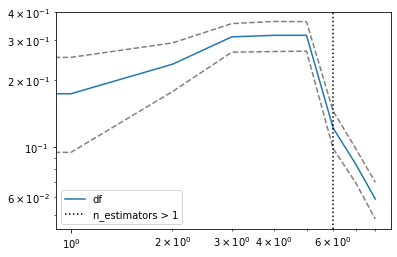

In [89]:
# X = 1 representation
mat = MW_norms
plt.plot(np.arange(len(mat)), np.mean(mat, axis=1), label='df')
plt.plot(np.arange(len(mat)), np.mean(mat, axis=1) + 2*np.sqrt(np.var(mat, axis=1)), ls='--', c='grey')
plt.plot(np.arange(len(mat)), np.mean(mat, axis=1) - 2*np.sqrt(np.var(mat, axis=1)), ls='--', c='grey')
plt.axvline(6, ls=':', c='black', label='n_estimators > 1')
plt.yscale('log')
plt.xscale('log')
plt.legend()
# plt.title(r'Average $||MW^T||_F$')
plt.show()

## NN "hat" matrix

In [90]:
from partition_decode.models import ReluNetClassifier, ReluNetRegressor
import torch

In [91]:
X_train, y_train = load_mnist(
    random_state=1,
    train=True,
    n_samples=1000,
    save_path="/mnt/ssd3/ronan/pytorch",
    onehot=True
)

X_test, y_test = load_mnist(
    random_state=1234,
    train=False,
    n_samples=10000,
    save_path="/mnt/ssd3/ronan/pytorch",
    onehot=True
)

from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()
X_train = min_max_scaler.fit_transform(X_train)
X_test = min_max_scaler.transform(X_test)

In [38]:
widths = [10, 13, 15, 17, 20, 30, 128]
gen_errors = []
irms = []
weights = []
train_errors = []
test_errors = []

prior_model = None
for n_hidden in widths:
    print(n_hidden, end=', ')
    model = ReluNetRegressor(
        verbose=0, n_epochs=1000, hidden_layer_dims=[n_hidden], batch_size=32,
        learning_rate=0.01, early_stop_thresh=0, bias=True)
    if prior_model is None or n_hidden > 100:
        model = model.fit(X_train, y_train)
    else:
        model._build_model(X_train.shape[-1], y_train.shape[1])
        with torch.no_grad():
            for prior_layer, new_layer in zip(prior_model.model_, model.model_,):
                if isinstance(new_layer, torch.nn.ReLU):
                    continue
                width, depth = prior_layer.weight.shape
                new_layer.weight[:width, :depth] = prior_layer.weight
                new_layer.bias[:width] = prior_layer.bias
        model._train_model(X_train, y_train)

    y_train_hat = model.predict(X_train)
    y_test_hat = model.predict(X_test)

    # train_errors.append(mean_squared_error(y_train, y_train_hat))
    # test_errors.append(mean_squared_error(y_test, y_test_hat))
    
    train_errors.append(zero_one_loss(y_train.argmax(1), y_train_hat.argmax(1)))
    test_errors.append(zero_one_loss(y_test.argmax(1), y_test_hat.argmax(1)))
    
    gen_errors.append(test_errors[-1] - train_errors[-1])
    irms.append(model.get_internal_representation(X_train))
    W, b, _ = model.get_affine_functions()
    weights.append(np.concatenate((b.reshape(*b.shape, 1), W), axis=-1))
    
    prior_model = model

10, 13, 15, 17, 20, 30, 128, 

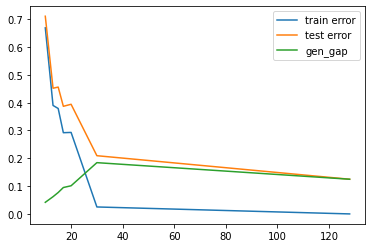

In [39]:
plt.plot(widths, train_errors, label='train error')
plt.plot(widths, test_errors, label='test error')
plt.plot(widths, gen_errors, label='gen_gap')
plt.legend()
# plt.yscale('symlog')
# plt.xscale('log')
plt.show()

In [52]:
MW_norms = np.asarray([
    [
        (np.linalg.norm(M @ W, ord=2) / np.sqrt(M.shape[0]))
        for W in Ws
    ] for M, Ws in zip(irms, weights)
])

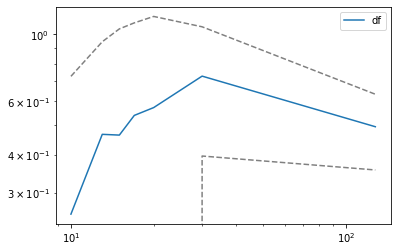

In [53]:
mat = MW_norms
# H diag(y) norm
plt.plot(widths, np.mean(mat, axis=1), label='df')
plt.plot(widths, np.mean(mat, axis=1) + 2*np.sqrt(np.var(mat, axis=1)), ls='--', c='grey')
plt.plot(widths, np.mean(mat, axis=1) - 2*np.sqrt(np.var(mat, axis=1)), ls='--', c='grey')
plt.yscale('log')
plt.xscale('log')
plt.legend()
# plt.title(r'Average $||MW||_F$')
plt.show()